Discard: Explorative

In [1]:
# Makes it easier to debug
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

In [2]:
import numpy as np
import pylab as plt
from scipy.linalg import inv
from scipy import stats
import scipy
import torch
import swyft
from swyft.networks.module import Module
from typing import Sequence
from swyft.networks.tail import _get_z_shape, _combine
from swyft.networks.normalization import OnlineNormalizationLayer
from swyft.networks.linear import LinearWithChannel
from torch import nn
from swyft.types import ObsType, SimShapeType
from scipy import ndimage

## Model

In [298]:
N = 100  # Number of data bins
SIGMA = 0.0  # Measurement uncertainty
NRES = 6

In [299]:
# Model and reference parameters
def spec(y, sigma, alpha):
    x = ndimage.gaussian_filter1d(y, sigma*10)*alpha
    return x

def model(v):
    x = spec(v[:-2], v[-2], v[-1])
    return dict(x=x)

# Noise model
def noise(sim, v):
    noise = np.random.randn(N)*SIGMA
    return dict(x = sim['x'] + noise)

# Prior
def transform(u):
    v = np.zeros_like(u)
    v[:-2] = scipy.stats.norm(0., 1.).ppf(u[:-2])
    v[-2] = u[-2]
    v[-1] = u[-1]+1
    return v

NPAR = N + 2

### Zoom in

In [300]:
sim = swyft.Simulator(model, NPAR, dict(x=(N,)))

In [301]:
prior = swyft.Prior(transform, NPAR, n = 1000)

In [302]:
NTRAIN = 10000

In [303]:
store = swyft.MemoryStore(sim)
store.add(NTRAIN, prior)
store.simulate()

Creating new store.
Store: Adding 9909 new samples to simulator store.


In [304]:
dataset = swyft.Dataset(NTRAIN, prior, store, simhook = noise)

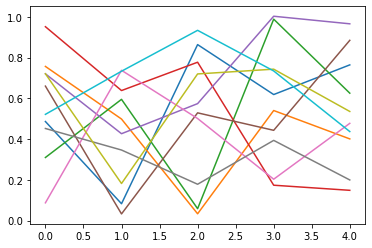

In [305]:
for i in range(10):
    plt.plot(dataset[i][0]['x'])

In [306]:
class MyNetXYZ(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv1d(4, 16, 3)
        self.c2 = nn.Conv1d(16, 32, 3)
        self.c3 = nn.Conv1d(32, 64, 3)
        self.c4 = nn.Conv1d(64, 128, 3)
        self.ac = nn.ReLU()
        self.mp = nn.MaxPool1d(2)
        self.l1 = nn.Linear(1024, 1024)
        self.l2 = nn.Linear(1024, 1024)
        self.l3 = nn.Linear(1024, 1)
        
    def forward(self, x):
        #x = x.unsqueeze(1)
        x = self.c1(x)
        x = self.ac(x)
        x = self.mp(x)
        x = self.c2(x)
        x = self.ac(x)
        x = self.mp(x)
        x = self.c3(x)
        x = self.ac(x)
        x = self.mp(x)
        x = self.c4(x)
        x = x.reshape(x.size()[0], -1)
        #x = x.reshape(-1, 1, 2, x.size()[-1])
        #x = torch.swapaxes(x, 2, 3)
        x = self.l1(x)
        x = self.ac(x)
        x = self.l2(x)
        x = self.ac(x)
        x = self.l3(x)
        return x

In [247]:
class MyTail(Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.net = MyNetXYZ()
        #self.l = nn.Linear(1, 1)

    def forward(self, f: torch.Tensor, params) -> torch.Tensor:
        #mn = MyNetXYZ().cuda()
        #x = mn(torch.rand(16, 4, 100).cuda())
        #print(x)
        #return None
        nbatch, _ = f.shape
        x = torch.zeros(nbatch, 4, 100).to(f.device)
        x[:,0,:] += params[:,:N]
        x[:,1,:] += f
        x[:,2,:] += params[:,N:N+1]
        x[:,3,:] += params[:,N+1:N+2]
        #print(x)
        #print(x.shape)
        #x = torch.rand(16, 4, 100).cuda()
        #net = MyNet().cuda()
        y = self.net(x) # nbatch, nmarg1, nmarg2, 2
        #y = self.l(y)
        #print(y)
        return y

In [248]:
post = swyft.Posteriors(dataset)
partition = range(1)
post.add(partition, device='cuda', head = swyft.DefaultHead, tail = MyTail)

In [249]:
post.train(partition, max_epochs = 100, scheduler_args = dict(patience = 1, factor = 0.5), early_stopping_patience = 5, 
           batch_size = 128, optimizer_args = dict(lr = 0.01))

Training: lr=0.00063, Epoch=22, VL=0.03252, TL=0.02274


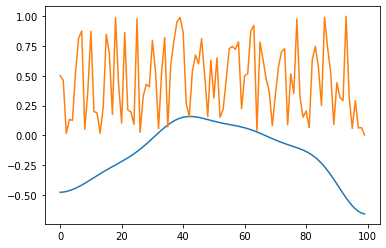

In [250]:
obs0, v0, u0 = dataset[0]
plt.plot(obs0['x'])
plt.plot(v0[:100])

In [251]:
tail = post._ratios[((0,),)].tail
head = post._ratios[((0,),)].head
f = head(dict(x = torch.tensor(obs0['x']).unsqueeze(0).float().cuda()))

/home/weniger/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [252]:
nbatch = 100
o = dict(x = torch.tensor(obs0['x']).unsqueeze(0).repeat(nbatch,1).float().cuda())
f = head(o)

/home/weniger/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [292]:
v = torch.rand(nbatch, 102).cuda()

In [293]:
vs = []
for _ in range(1000):
    vs.append(v.detach().cpu())
    v.requires_grad = True
    r = tail(f, v)
    loss = -sum(r)
    loss.backward()
    #print(loss)
    epsilon = 1e-3
    v = v - epsilon * v.grad
    v = v.detach()
#v.grad.zero_()

In [294]:
u = vs[-1][0].numpy()
v = transform(u)
print(u)
print(v)
#x = model()['x']
#plt.plot(x)
#plt.plot(obs0['x'])

[ 1.2377645   1.0951892   1.0067643  -0.66266346 -0.78559715  0.24695002
  1.7669735   1.5010753   0.8909846   0.09674866  0.19757597  0.16194151
  0.7670727   0.5196734   1.1896718  -0.37609038  0.12618858  0.52224416
  0.7280138   0.3068429   0.5304909   0.42440522  0.5900276   0.5539243
  0.53378975  0.57204205  0.8635766  -0.34246513  0.5890221   0.16136938
 -0.0182543   0.39508316  0.68179137  1.8695548   0.29151365  0.6893972
  0.48623225  0.79881334  0.20622057  0.68811333  0.7669362   0.09361894
  0.26992857 -0.02389372  0.7713508   1.9898937   1.5062416   0.1421229
  0.4998259   0.6736548   0.4198385   0.48151067  0.59845257  0.73552716
 -0.2406909   0.74318063  0.47831005  0.39029643  1.2561147   0.590632
  0.9220872   0.32025042  0.8829594   0.35573316  0.92673254  0.7985371
 -0.14468434  0.17498247  0.45667318  0.1727564   0.7081199   1.3537242
  0.5862462   1.2416078  -0.1470371   0.11917093  1.4074275   0.9096548
  0.6107406  -0.28751102 -0.40013057 -0.19983801  0.5994738